# Importação de Bibliotecas

In [28]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.api.datasets import cifar10
from keras.api.models import Sequential
from keras.api.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.api.utils import to_categorical, image_dataset_from_directory
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.api.preprocessing import image

from tensorflow._api.v2.data import Dataset

from sklearn.model_selection import StratifiedKFold

from typing import ByteString
from enum import Enum

from utils.model_utils import plot_image, print_history, salvar_modelo

# Importação do dataset e Tratativas

In [29]:
datasets_path = os.path.join(os.getcwd(), 'datasets', 'cat_dog')

## Data Agumentation

In [30]:
# Data agmentation virou layers....
# https://keras.io/api/layers/preprocessing_layers/image_augmentation/
gerador_treinamento = ImageDataGenerator(
    rescale = 1.0/255, # Coloca os valores de cor da imagem entre 0 e 1.
    rotation_range=7,
    horizontal_flip=True, # Rotaciona imagem
    shear_range=0.2, # Muda a direção dos pixels
    height_shift_range=0.07, # Mudança da altura
    zoom_range=0.2 # Mudança do zoom
)
gerador_teste = ImageDataGenerator(
    rescale = 1.0/255, # Coloca os valores de cor da imagem entre 0 e 1.
)

# NOVO JEITO DE IMPORTAR DADOS
# https://keras.io/api/data_loading/image/
# entradas_treino: Dataset = image_dataset_from_directory(
#     directory = os.path.join(datasets_path, 'training_set'),
#     labels='inferred',
#     label_mode='binary',
#     color_mode='grayscale',
#     batch_size=32,
#     image_size=(64, 64)
# )

# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory
# Por estar separado em diretórios, cachorrro e gato, é identificado automaticamente que as imagens dentro de cada pasta, 
## pertencem a class com o nome da pasta (cachorro ou gato). Pode-se adicionar novas pastas para novos targets.
dataset_treino = gerador_treinamento.flow_from_directory(
    directory= os.path.join(datasets_path, 'training_set'),
    target_size= (64, 64),
    batch_size=32,
    class_mode= 'binary'
)

dataset_teste = gerador_treinamento.flow_from_directory(
    directory= os.path.join(datasets_path, 'test_set'),
    target_size= (64, 64),
    batch_size=32,
    class_mode= 'binary'
)

Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Criação do Modelo

In [31]:
def criar_modelo() -> Sequential:
    # Criação modelo e entrada
    modelo = Sequential(
        name='Cat_Dogs',
        layers=[
            Input(
                shape=(64, 64, 3)
            )
        ]
    )

    # Criação da Camada 1 de Convolução
    modelo.add(
        Conv2D(
            filters=32,
            kernel_size=(3, 3),
            padding='same',
            activation='relu' # Retira valores negativos (partes mais escuras da imagem)
        )
    )
    modelo.add(BatchNormalization())
    modelo.add(
        MaxPooling2D(
            pool_size=(2, 2)
        )
    )

    # Criação da Camada 2 de Convolução
    modelo.add(
        Conv2D(
            filters=32,
            kernel_size=(4, 4),
            padding='same',
            activation='relu' # Retira valores negativos (partes mais escuras da imagem)
        )
    )
    modelo.add(BatchNormalization())
    modelo.add(
        MaxPooling2D(
            pool_size=(2, 2)
        )
    )

    # Camada de Flatten - vetorização da imagem
    modelo.add(Flatten())

    # Modelo da rede neural densa
    modelo.add(
        Dense(
            units=128,
            activation='relu'
        )
    )
    modelo.add(
        Dropout(0.2)
    )
    modelo.add(
        Dense(
            units=128,
            activation='relu'
        )
    )
    modelo.add(
        Dropout(0.2)
    )
    
    modelo.add(
        Dense(
            units=1,
            activation='sigmoid'
        )
    )

    # Método de compilação
    modelo.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )


    return modelo

In [32]:
modelo = criar_modelo()

In [33]:
resultados = modelo.fit(
    x= dataset_treino,
    steps_per_epoch= int(4000/32),
    epochs= 10,
    validation_data= dataset_teste,
    validation_steps= int(1000/32)
)

print_history(resultados)
salvar_modelo(
    modelo=modelo,
    path=os.path.join(os.getcwd(), 'models', 'cat_dog')
)

Epoch 1/10


c:\Users\joao.turra\Documents\Git\machine-learning\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.5425 - loss: 1.0075 - val_accuracy: 0.5565 - val_loss: 0.6969
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.6540
Epoch 3/10


C:\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - accuracy: 0.6059 - loss: 0.6707 - val_accuracy: 0.5151 - val_loss: 1.0851
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 1.4935
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - accuracy: 0.6307 - loss: 0.6397 - val_accuracy: 0.5877 - val_loss: 0.7406
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2500 - val_loss: 1.6079
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 115ms/step - accuracy: 0.6580 - loss: 0.6155 - val_accuracy: 0.5756 - val_loss: 0.6928
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.5021
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 114ms/step - accuracy: 0.6483 - loss: 0.6174 - val_accuracy: 0.6895 - val_loss: 0.6086
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - accuracy: 0.0000

ValueError: The filename must end in `.weights.h5`. Received: filepath=c:\Users\joao.turra\Documents\Git\machine-learning\models\cat_dog\Cat_Dogs.pesos.h5

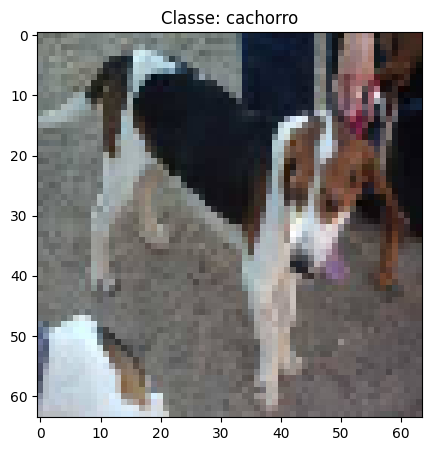

In [ ]:
classe = 'cachorro'
classe_en = 'dog' if classe == 'cachorro' else 'cat'
indice = 3500

imagem_teste = image.load_img(
    f"datasets/cat_dog/test_set/{classe}/{classe_en}.{indice}.jpg",
    target_size=(64, 64),
)
imagem_teste = image.img_to_array(imagem_teste)
imagem_teste /= 255

plot_image(imagem_teste, classe, figsize=(5,5))

# Expande a dimensão da imagem para colocar no formato que o tensorflow trabalha com a imagens
imagem_teste = np.expand_dims(imagem_teste, axis=0)

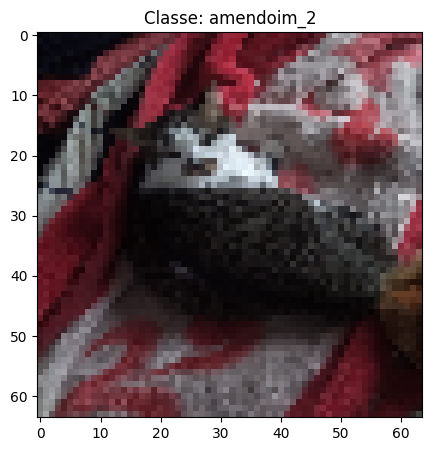

In [57]:
imagem = 'amendoim_2'
imagem_teste = image.load_img(
    f"datasets\playground\{imagem}.jpeg",
    target_size=(64, 64),
)
imagem_teste = image.img_to_array(imagem_teste)
imagem_teste /= 255

plot_image(imagem_teste, imagem, figsize=(5,5))

# Expande a dimensão da imagem para colocar no formato que o tensorflow trabalha com a imagens
imagem_teste = np.expand_dims(imagem_teste, axis=0)

In [60]:
previsao = modelo.predict(imagem_teste)
classes = dataset_treino.class_indices


previsao_int = int(previsao[0][0] > 0.5)

print("Previsão: {} - Classe: {}".format(
    np.round(previsao[0][0], 3),
    list(classes.items())[previsao_int][0]
))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Previsão: 0.5410000085830688 - Classe: gato
